## Кластеризация статей по темам, используя название и краткое содержание 

In [1]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
import gensim
from gensim.models import LdaModel
from gensim import models, corpora, similarities
import re
from nltk.stem.porter import PorterStemmer
import time
from nltk import FreqDist
from scipy.stats import entropy
import seaborn as sns
sns.set_style("darkgrid")
nltk.download('stopwords')
nltk.download('punkt')
import pyLDAvis
import pyLDAvis.gensim 
import matplotlib.pyplot as plt
from gensim.models import CoherenceModel
import warnings
warnings.filterwarnings('ignore')
from wordcloud import WordCloud
%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ezdoronok\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ezdoronok\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [59]:
df = pd.read_csv('nature_10.csv', sep = '\t', header = None) # считал датасет
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,Chromatin remodeling regulated by steroid and ...,Cell Research,1748-7838,10.1038/cr.1997.14,7.0,2.0,1997.0,127-142,"Wolffe, Alan P","Wolffe, Alan P#:#Laboratory of Molecular Embro...",Coactivators and corepressors regulate transcr...,citation_journal_title=Ann Rev Genet; citation...,NaN
1,Biochemical detection of alien DNA incorporate...,Heredity,1365-2540,10.1038/hdy.1978.49,40.0,3.0,1978.0,439-455,"Flavell, Richard;O'Dell, Michael;Rimpau, Jürge...","Flavell, Richard#:#Department of Cytogenetics,...",Wheat lines carrying homologous pairs of compl...,"Barber, H N, Driscoll, C J, and Vickery, R S. ...",NaN
2,Early Archaean Age for the Isua Iron Formation...,Nature,1476-4687,10.1038/245138a0,245.0,5421.0,1973.0,138-139,"MOORBATH, S.;O'NIONS, R. K.;PANKHURST, R. J.","MOORBATH, S.#:#Department of Geology, Universi...","SOME 150 km north-east of Godthaab, on the edg...",citation_journal_title=Nature; citation_author...,NaN
3,Technical Education Abstracts,Nature,1476-4687,10.1038/193222a0,193.0,4812.0,1962.0,222-222,NaN,NaN,NaN,NaN,NaN
4,The Utility of Specific Characters,Nature,1476-4687,10.1038/054365b0,54.0,1399.0,1896.0,365-366,"LANKESTER, E. RAY","LANKESTER, E. RAY#:#Dinard, Bretagne",I REGRET very much that I did not correctly re...,NaN,NaN


In [60]:
df = df.rename({0:'title', 1:'journal', 2:'eissn',3:'doi',4:'volume',
                5:'issue',6:'year',7:'pages',8:'author',9:'affiliation',
               10:'text', 11:'citation', 12:'contacts'}, axis = 1) #переименовал колонки

In [61]:
df.shape

(10000, 13)

In [62]:
df[df['text'].isna() == False].shape 

(7805, 13)

In [63]:
df = df[df['text'].isna() == False] #избавлюсь от тех семплов, где нету краткого содержания статьи

In [64]:
df['title'].fillna(value="", inplace=True) # заменю пустые значения названий

In [65]:
# перемешиваю сэмплы
df = df.sample(frac=1.0)
df.reset_index(drop=True,inplace=True)
df.head()

,title,journal,eissn,doi,volume,issue,year,pages,author,affiliation,text,citation,contacts
0,SPATA33 is an autophagy mediator for cargo sel...,Cell Death & Differentiation,1476-5403,10.1038/s41418-020-00638-2,28.0,3.0,2021.0,1076-1090,"Zhang, Ying;Xu, Xu;Hu, Mengxin;Wang, Xin;Cheng...","Zhang, Ying#:#Hubei Key Laboratory of Cell Hom...",Selective autophagic degradation of mitochondr...,citation_journal_title=Microsc Res Tech.; cita...,Hanhua Cheng#:#hhcheng@whu.edu.cn#;#Rongjia Zh...
1,Carbohydrate recognition by Clostridium diffic...,Nature Structural & Molecular Biology,1545-9985,10.1038/nsmb1084,13.0,5.0,2006.0,460-461,"Greco, Antonio;Ho, Jason G S;Lin, Shuang-Jun;P...","Greco, Antonio#:#Alberta Ingenuity Centre for ...",Clostridium difficile TcdA is a large toxin th...,citation_journal_title=N. Engl. J. Med.; citat...,Kenneth K-S Ng#:#ngk@ucalgary.ca
2,Redshifts of 1548 + 115a and 1548 + 115b in th...,Nature,1476-4687,10.1038/250127a0,250.0,5462.0,1974.0,127-128,"CHERRY, NORMAN H.","CHERRY, NORMAN H.#:#University City Science Ce...",IN a recent communication Wampler et al.1 repo...,citation_journal_title=Nature; citation_author...,NaN
3,Ocean sensitivity to freshwater,Nature Climate Change,1758-6798,10.1038/s41558-022-01324-6,12.0,5.0,2022.0,419-420,"Bakker, Pepijn","Bakker, Pepijn#:#Department of Earth Sciences,...",In response to future warming and freshening o...,citation_journal_title=Nat. Clim. Change; cita...,Pepijn Bakker#:#p.bakker@vu.nl
4,Transplantation of Murine Leukæmia by Unconven...,Nature,1476-4687,10.1038/1911213a0,191.0,4794.0,1961.0,1213-1214,"HEWITT, HAROLD B.","HEWITT, HAROLD B.#:#John Burford Carlill Labor...",A LYMPHOCYTIC type of leukæmia which arose spo...,citation_journal_title=Brit. J. Cancer; citati...,NaN


In [66]:
def initial_clean(text):
    """
    Функция, которая чистит текст от ссылок, адресов почт и пунктуации.
    Также приводит текст к нижнему регистру
    """
    text = re.sub("((\S+)?(http(s)?)(\S+))|((\S+)?(www)(\S+))|((\S+)?(\@)(\S+)?)", " ", text)
    text = re.sub("[^a-zA-Z ]", "", text)
    text = text.lower()
    text = nltk.word_tokenize(text)
    return text

stop_words = stopwords.words('english')
def remove_stop_words(text):
    """
    Избавляюсь от стоп-слов
    """
    return [word for word in text if word not in stop_words]

stemmer = PorterStemmer()
def stem_words(text):
    """
    Привожу слова к основам слов
    """
    text = [stemmer.stem(word) for word in text]
    text = [word for word in text if len(word) > 1] # Избавляюсь от 1 символьных слов 
    return text

def apply_all(text):
    """
    Применяю все функции обработки текста
    """
    return stem_words(remove_stop_words(initial_clean(text)))

In [67]:
%%time
df['tokenized'] = df['text'].apply(apply_all) + df['title'].apply(apply_all) # Очищаю текст и название 

Wall time: 21 s


In [68]:
# Получаю список всех слов встречающихся в текстах
all_words = [word for item in list(df['tokenized']) for word in item]
# Используя библиотеку nltk, получаю словарь с частотой слов
fdist = FreqDist(all_words)
len(fdist) # Количество уникальных слов

48336

In [69]:
top_k_words = fdist.most_common()

In [70]:
# оставляю лишь те слова, которые встречаются хотя бы 14 раз
top_k_words = [x for x in top_k_words if x[1] >= 14]

In [71]:
len(top_k_words)

6166

In [72]:
# Чищу текста от токенов, которые встречаются меньше чем 14 раз
top_k_words,_ = zip(*top_k_words)
top_k_words = set(top_k_words)
def keep_top_k_words(text):
    return [word for word in text if word in top_k_words]

In [74]:
df['tokenized'] = df['tokenized'].apply(keep_top_k_words)

In [75]:
# Теперь, посчитаю длину текстов после преобразований
doc_lengths = df['tokenized'].apply(len).values


print("Всего текстов:",len(doc_lengths),
      "\nСредняя длина текста:", np.average(doc_lengths),
      "\nМинимальная длина текста:", min(doc_lengths),
      "\nМаксимальная длина текста:", max(doc_lengths))

Всего текстов: 7805 
Средняя длина текста: 97.35874439461884 
Минимальная длина текста: 0 
Максимальная длина текста: 963


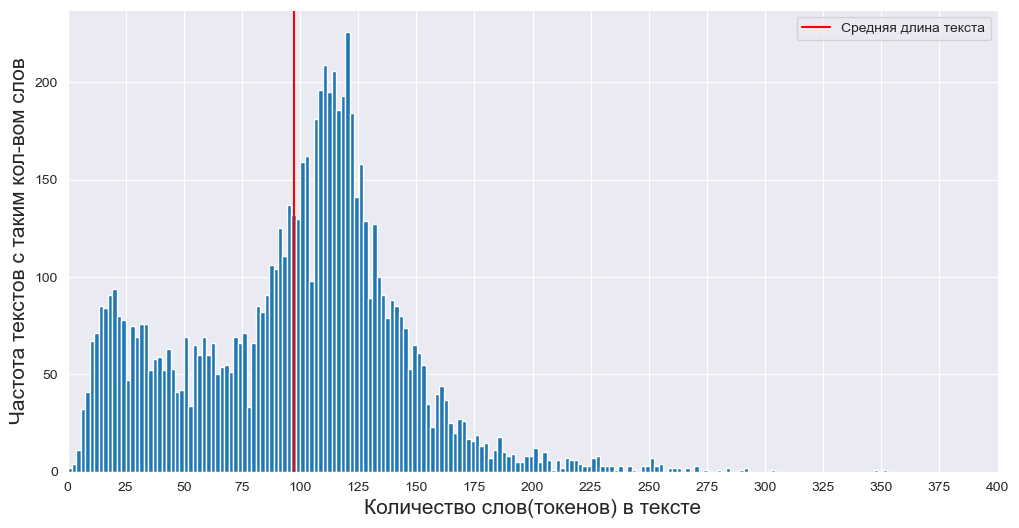

In [76]:
# Строю гистограмму, чтобы посмотреть распределение длин текстов
fig, ax = plt.subplots(figsize=(12,6))
n, bins, patches = ax.hist(doc_lengths, 500)
ax.set_xlabel('Количество слов(токенов) в тексте', fontsize=15)
ax.set_ylabel('Частота текстов с таким кол-вом слов', fontsize=15)
ax.grid()
ax.set_xticks(np.linspace(0,400, 17))
plt.xlim(0,400)
plt.axvline(np.average(doc_lengths), color = 'red', label='Средняя длина текста')
ax.legend()
ax.grid()
plt.show()

In [77]:
# Оставляю только те статьи, в которых кол-во токенов больше 10, иначе слишком короткие тексты
df = df[df['tokenized'].map(len) >= 10]
df.reset_index(drop=True,inplace=True)
print("После чистки и исключения коротких статей в датафрейме осталось:", len(df), "статей")

После чистки и исключения коротких статей в датафрейме осталось: 7715 статей


In [78]:
num_topics = 22 
dictionary = corpora.Dictionary(df['tokenized']) 
corpus = [dictionary.doc2bow(doc) for doc in df['tokenized']]
'''
Я выбрал количество тем, на которые разобьет модель мои тексты. Далее забрасываю список текстов в класс Dictionary,
создавая словарь, в котором каждому слову присваивается id. Теперь получаю список corpus, в котором хранятся списки картежей.
В картеже хранятся пара чисел вида (слово, частота).
'''
pass

In [79]:
corpus[0]

[(0, 1),
 (1, 1),
 (2, 4),
 (3, 2),
 (4, 2),
 (5, 1),
 (6, 1),
 (7, 1),
 (8, 1),
 (9, 1),
 (10, 2),
 (11, 1),
 (12, 1),
 (13, 2),
 (14, 1),
 (15, 1),
 (16, 1),
 (17, 1),
 (18, 1),
 (19, 1),
 (20, 1),
 (21, 1),
 (22, 1),
 (23, 2),
 (24, 1),
 (25, 3),
 (26, 3),
 (27, 1),
 (28, 1),
 (29, 1),
 (30, 1),
 (31, 1),
 (32, 2),
 (33, 1),
 (34, 2),
 (35, 1),
 (36, 3),
 (37, 1),
 (38, 1),
 (39, 1),
 (40, 1),
 (41, 1),
 (42, 1),
 (43, 1),
 (44, 2)]

In [80]:
%%time
lda = LdaModel(corpus=corpus, 
               num_topics=num_topics, 
               id2word=dictionary,
               random_state=100,
               update_every=1,
               chunksize=100,
               passes=10,
               alpha='auto',
               per_word_topics=True)

Wall time: 27.1 s


In [81]:
lda.print_topics(num_topics=10, num_words=20) #модель выделила темы в наших текстах и представила для них ключевые слова

[(10,
  '0.335*"abnorm" + 0.235*"breast" + 0.110*"neural" + 0.062*"biopsi" + 0.041*"commerci" + 0.036*"metastat" + 0.023*"ip" + 0.023*"fire" + 0.007*"tdm" + 0.004*"perhap" + 0.000*"rb" + 0.000*"prognost" + 0.000*"fish" + 0.000*"mm" + 0.000*"myeloma" + 0.000*"advers" + 0.000*"er" + 0.000*"twist" + 0.000*"milk" + 0.000*"sole"'),
 (18,
  '0.378*"protein" + 0.102*"bind" + 0.096*"membran" + 0.050*"nuclear" + 0.047*"degrad" + 0.047*"recruit" + 0.044*"mitochondri" + 0.027*"autophagi" + 0.021*"termin" + 0.015*"outer" + 0.014*"knockout" + 0.014*"microbiota" + 0.012*"mitochondria" + 0.011*"autophagosom" + 0.010*"machineri" + 0.008*"ntermin" + 0.006*"harbor" + 0.006*"rrna" + 0.005*"compon" + 0.005*"testi"'),
 (20,
  '0.116*"network" + 0.084*"transit" + 0.063*"connect" + 0.052*"symptom" + 0.045*"kidney" + 0.037*"renal" + 0.037*"function" + 0.036*"precursor" + 0.029*"relax" + 0.027*"hydrogen" + 0.027*"architectur" + 0.026*"rs" + 0.025*"cognit" + 0.025*"motor" + 0.025*"liquid" + 0.024*"onset" + 0.02

#### Увидев ключевые слова, мы можем интерпретировать темы. 
#### Перед каждым словом представлен его вес в теме, например тема 18: Протеины и связанные процессы. В данной теме основное внимание уделяется протеинам и различным процессам, связанным с ними. Упоминаются понятия, такие как "protein" (протеин), "bind" (связываться), "membran" (мембрана), "nuclear" (ядерный), "degrad" (деградация), "recruit" (рекрутирование), "mitochondri" (митохондрии) и другие. Эти термины указывают на процессы взаимодействия протеинов с мембранами, митохондриями, а также на их вовлечение в деградацию и рекрутирование.

In [82]:
#Выбираю случайную статью, для того чтобы посмотреть к какой теме она наибольше всего относится
random_article_index = np.random.randint(len(df))
bow = dictionary.doc2bow(df.iloc[random_article_index,13])
print(random_article_index)

5614


In [83]:
print(df.iloc[random_article_index,10])

We herein report an association between TMEM132D and panic disorder (PD) in a Japanese population, evaluating the effects of HLA-DRB1*13:02, which we previously reported as a susceptibility genetic factor for PD. SNPs in TMEM132D showed significant associations with PD in subjects without HLA-DRB1*13:02 (rs4759997; P=5.02×10−6, odds ratio=1.50) but not in those with the HLA allele. TMEM132D might have a role in the development of PD in subjects without HLA-DRB1*13:02.


#### Перевод статьи
Здесь мы сообщаем о связи между TMEM132D и паническим расстройством (PD) в японской популяции, оценивая эффекты HLA-DRB1*13:02, о котором мы ранее сообщали как о генетическом факторе предрасположенности к PD. SNP в TMEM132D показали значимую ассоциацию с БП у субъектов без HLA-DRB1*13:02 (rs4759997; P=5,02×10-6, отношение шансов=1,50), но не у лиц с аллелем HLA. TMEM132D может играть определенную роль в развитии БП у субъектов без HLA-DRB1*13:02.

In [84]:
doc_distribution = np.array([(int(tup[0]), tup[1]) for tup in lda.get_document_topics(bow=bow)])
#получаю список списков, в которых хранится id темы и с какой вероятностью текст принадлежит к ней

In [85]:
doc_distribution

array([[0.00000000e+00, 1.12938704e-02],
       [1.00000000e+00, 2.06221100e-02],
       [3.00000000e+00, 4.13202345e-02],
       [7.00000000e+00, 1.55100850e-02],
       [8.00000000e+00, 8.96204412e-02],
       [1.20000000e+01, 6.24979176e-02],
       [1.30000000e+01, 1.84717163e-01],
       [1.40000000e+01, 1.68640822e-01],
       [1.60000000e+01, 6.24432862e-02],
       [1.70000000e+01, 3.48965563e-02],
       [1.90000000e+01, 9.57986638e-02],
       [2.00000000e+01, 1.02170981e-01],
       [2.10000000e+01, 5.65770343e-02]])

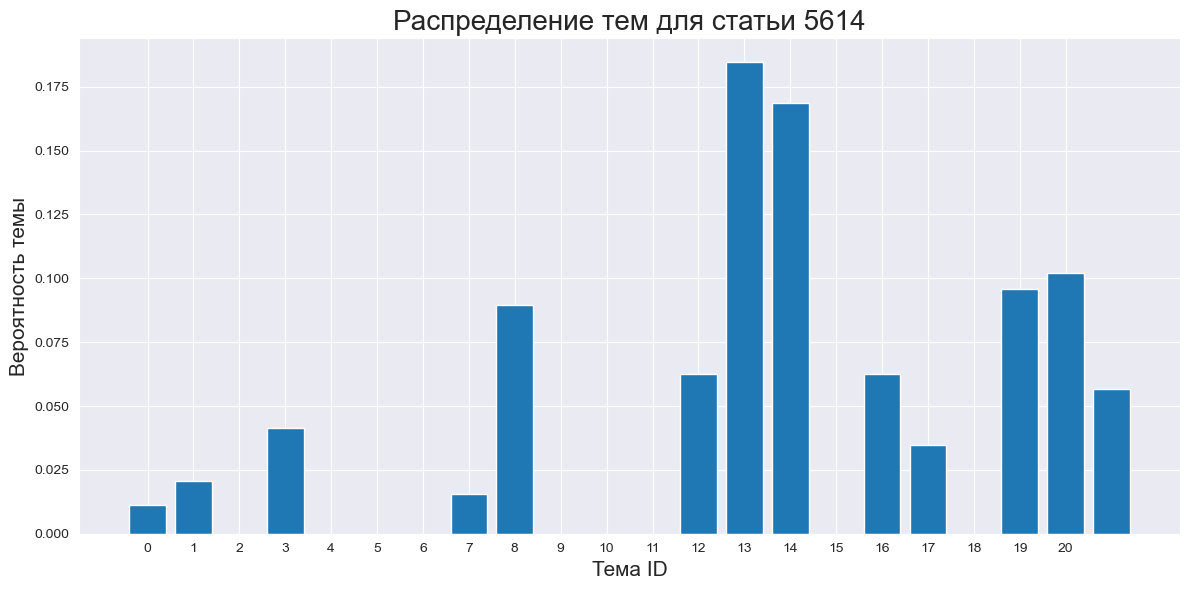

In [86]:
fig, ax = plt.subplots(figsize=(12,6));
patches = ax.bar([i[0] for i in doc_distribution], [i[1] for i in doc_distribution])
ax.set_xlabel('Тема ID', fontsize=15)
ax.set_ylabel('Вероятность темы', fontsize=15)
ax.set_title("Распределение тем для статьи " + str(random_article_index), fontsize=20)
ax.set_xticks(np.linspace(0,20,21))
fig.tight_layout()
plt.show()

In [87]:
# топ-3 самых вероятных тем для статьи 
for i in sorted(doc_distribution, key = lambda x: x[1], reverse=True)[:3]:
    print(i, lda.show_topic(topicid=int(i[0]), topn=10), "\n")

[13.          0.18471716] [('gene', 0.09567926), ('identifi', 0.032825306), ('genet', 0.032259222), ('dna', 0.030286081), ('mutat', 0.028214829), ('sequenc', 0.024240136), ('genom', 0.02341065), ('region', 0.022404943), ('disord', 0.018771144), ('variant', 0.018289225)] 

[14.          0.16864082] [('studi', 0.063205086), ('associ', 0.044105474), ('group', 0.04104858), ('analysi', 0.03108874), ('compar', 0.028870651), ('signific', 0.0248062), ('risk', 0.023834812), ('rate', 0.022842702), ('use', 0.022488544), ('differ', 0.02180283)] 

[20.          0.10217098] [('network', 0.11578604), ('transit', 0.08379878), ('connect', 0.0631962), ('symptom', 0.052086335), ('kidney', 0.044642754), ('renal', 0.037451286), ('function', 0.0369353), ('precursor', 0.036125235), ('relax', 0.02935271), ('hydrogen', 0.027445318)] 



### Данная статья с вероятностью 0.18 относится к 13 теме - тема посвящена генам и генетическим процессам, с вероятностью 0.168 относится к 14 теме - исследования и анализ данных , с вероятностью 0.10 относится к 20 теме - рассматриваются сети и связи между элементами.

### Читая перевод статьи, понимаю, что она действительно больше всего подходит к 13 теме

### Оценка модели
### Для оценки буду использовать метрику когертность (Coherence). Метрика когерентности предоставляет количественную оценку качества кластеризации текстов и измеряет степень связности терминов внутри кластеров. Она позволяет оценить, насколько хорошо кластеры отражают семантическую структуру данных. Более высокое значение когерентности указывает на более согласованные и осмысленные кластеры.

In [88]:
coherence_model_lda = CoherenceModel(model=lda, texts=df['tokenized'].tolist(), dictionary=dictionary)
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.4052743183016506


#### Метрика показала невысокий результат, постараемся ее приблизить к единице, путем изменения количества тем для разбиения.

## Визуализация темы и ключевых слов

In [89]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda, corpus, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
19    -0.245383  0.008565       1        1  17.934880
8     -0.222176 -0.064402       2        1  12.606758
17    -0.119015 -0.138539       3        1   8.115076
14    -0.196482  0.074063       4        1   8.071242
1     -0.142990 -0.033303       5        1   6.192746
16    -0.150656  0.199934       6        1   6.043940
3     -0.064701 -0.234933       7        1   5.729186
13    -0.146786 -0.122568       8        1   5.168272
7     -0.112659  0.162238       9        1   4.879802
0      0.045252 -0.050604      10        1   4.339071
5      0.040050  0.079904      11        1   2.827689
12     0.026267  0.202622      12        1   2.787638
2      0.084370 -0.101184      13        1   2.562437
6      0.076756  0.057480      14        1   2.347793
15     0.120003  0.070259      15        1   1.863369
11     0.140424 -0.028825      16        1   1.686787
21     0.132556 -0.086310      17        1   1.584289
9      0.137583  0.065786      18        1   1.393704
4      0.146105  0.071848      19        1   1.255755
18     0.157579 -0.028993      20        1   1.180711
20     0.127113 -0.087147      21        1   1.091400
10     0.166791 -0.015891      22        1   0.337454, topic_info=          Term         Freq        Total Category  logprob  loglift
7         cell  9966.000000  9966.000000  Default  30.0000  30.0000
547    patient  5249.000000  5249.000000  Default  29.0000  29.0000
34     protein  3388.000000  3388.000000  Default  28.0000  28.0000
623       gene  3755.000000  3755.000000  Default  27.0000  27.0000
273        use  6160.000000  6160.000000  Default  26.0000  26.0000
...        ...          ...          ...      ...      ...      ...
2875  transloc     0.051653     1.279587  Topic22 -10.8118   2.4818
3158   shorten     0.051653     1.279580  Topic22 -10.8118   2.4818
3592    retain     0.051653     1.279581  Topic22 -10.8118   2.4818
2447   display     0.051653     1.279588  Topic22 -10.8118   2.4817
4475   autolog     0.051653     1.279584  Topic22 -10.8118   2.4817

[956 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
887      22  0.997995  abnorm
1838     17  0.781606  absenc
1838     18  0.085439  absenc
1838     20  0.132905  absenc
2080     19  0.985400  absorb
...     ...       ...     ...
132       6  0.294038    year
132       9  0.386860    year
132      12  0.319190    year
1698      3  0.995146   yield
1583      9  0.993590    zone

[1357 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[20, 9, 18, 15, 2, 17, 4, 14, 8, 1, 6, 13, 3, 7, 16, 12, 22, 10, 5, 19, 21, 11])

### Кругами на левом графике представлены темы. Чем больше круг, тем больше токенов входит в него, соответсвенно тем больше распространена эта тема.

### Хорошая тематическая модель будет иметь довольно большие непересекающиеся круги, разбросанные по всей диаграмме, а не сгруппированные в одном квадранте. Модель со слишком большим количеством тем, как правило, имеет много перекрытий, круги небольшого размера, сгруппированные в одной области диаграммы.
### Поскольку у меня вышло много маленьких пересекающихся кругов, то следует уменьшить количество тем и попробовать другие гиперпараметры.

In [90]:
from tqdm import tqdm

In [91]:
# Перебираю количество тем, чтобы получить лучшую метрику
best_coh = 0
best_n = 0
coherence_values = []
model_list = []
for num_topics in tqdm(range(2,31,2)):
    
    lda = LdaModel(corpus=corpus, 
                   num_topics=num_topics, 
                   id2word=dictionary,
                   random_state=100,
                   update_every=1,
                   chunksize=100,
                   passes=10,
                   alpha='auto',
                   per_word_topics=True)
    coherence_model_lda = CoherenceModel(model=lda, texts=df['tokenized'].tolist(), dictionary=dictionary)
    coherence_lda = coherence_model_lda.get_coherence()
    if coherence_lda>best_coh:
        best_coh = coherence_lda
        best_n = num_topics
        best_lda = lda
        print(best_coh, best_n)
    model_list.append(lda)
    coherence_values.append(coherence_lda)

  7%|█████▌                                                                             | 1/15 [00:22<05:21, 22.94s/it]

0.35720851891253963 2


 13%|███████████                                                                        | 2/15 [00:48<05:17, 24.42s/it]

0.47128336557316697 4


 20%|████████████████▌                                                                  | 3/15 [01:14<05:02, 25.19s/it]

0.480259438504311 6


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [08:34<00:00, 34.30s/it]


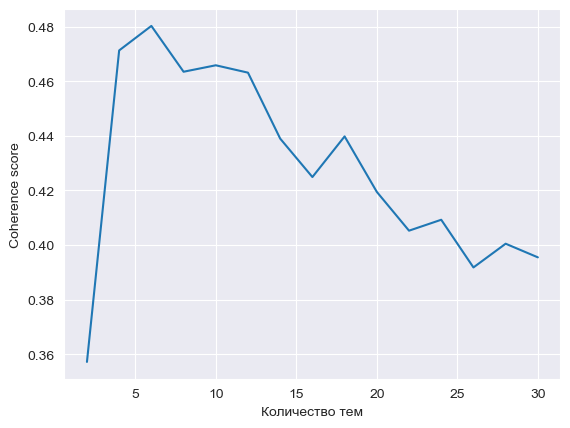

In [92]:
x = range(2, 31, 2)
plt.plot(x, coherence_values)
plt.xlabel("Количество тем")
plt.ylabel("Coherence score")
plt.show()

#### Как видно из графика, показатель согласованности быстро увеличивается, затем постепенно снижается. Наилучший показатель достигается при 6 темах.

In [93]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(best_lda, corpus, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.128488  0.157839       1        1  22.197479
3      0.032945 -0.252945       2        1  18.446133
5      0.210689  0.071260       3        1  17.771533
2     -0.258872 -0.050183       4        1  15.852617
0      0.071460 -0.102581       5        1  12.953041
4     -0.184710  0.176609       6        1  12.779198, topic_info=        Term         Freq        Total Category  logprob  loglift
7       cell  8172.000000  8172.000000  Default  30.0000  30.0000
547  patient  4457.000000  4457.000000  Default  29.0000  29.0000
318  express  3134.000000  3134.000000  Default  28.0000  28.0000
623     gene  3026.000000  3026.000000  Default  27.0000  27.0000
290    activ  3961.000000  3961.000000  Default  26.0000  26.0000
..       ...          ...          ...      ...      ...      ...
308  control   503.316783  1883.572693   Topic6  -5.2615   0.7376
166     show   517.598243  3403.600300   Topic6  -5.2336   0.1740
189    induc   440.126834  1283.657206   Topic6  -5.3957   0.9869
238     role   439.017886  1478.715541   Topic6  -5.3982   0.8430
70   suggest   436.514574  1784.657312   Topic6  -5.4039   0.6492

[384 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
887       1  0.875375  abnorm
887       4  0.123723  abnorm
1662      1  0.042860  access
1662      3  0.955167  access
288       2  0.412008    acid
...     ...       ...     ...
1136      3  0.995049    wave
610       2  0.997866     way
2047      1  0.997683   women
132       1  0.842472    year
132       3  0.157137    year

[633 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 4, 6, 3, 1, 5])

### Теперь получилось, что на левом графике круги увеличились и перестали перекрывать друг друга.

### Рассмотрим на какие темы разбила модель статьи

In [94]:
best_lda.print_topics(num_words=10)

[(0,
  '0.022*"gene" + 0.013*"genet" + 0.010*"associ" + 0.010*"identifi" + 0.009*"mutat" + 0.008*"analysi" + 0.008*"human" + 0.008*"popul" + 0.008*"dna" + 0.008*"transplant"'),
 (1,
  '0.026*"patient" + 0.013*"studi" + 0.010*"group" + 0.010*"use" + 0.008*"associ" + 0.007*"risk" + 0.006*"age" + 0.006*"year" + 0.006*"clinic" + 0.006*"treatment"'),
 (2,
  '0.068*"cell" + 0.026*"express" + 0.018*"cancer" + 0.015*"activ" + 0.014*"protein" + 0.012*"regul" + 0.009*"target" + 0.009*"factor" + 0.009*"tumor" + 0.008*"pathway"'),
 (3,
  '0.014*"structur" + 0.014*"use" + 0.008*"system" + 0.008*"quantum" + 0.007*"demonstr" + 0.007*"organ" + 0.007*"mechan" + 0.007*"effici" + 0.006*"provid" + 0.006*"phase"'),
 (4,
  '0.017*"effect" + 0.016*"activ" + 0.012*"increas" + 0.011*"metabol" + 0.011*"mice" + 0.010*"receptor" + 0.009*"respons" + 0.008*"stress" + 0.007*"neuron" + 0.007*"function"'),
 (5,
  '0.011*"measur" + 0.008*"observ" + 0.007*"result" + 0.006*"time" + 0.006*"effect" + 0.006*"show" + 0.005*"

### Представлю ключевые слова каждой темы в виде облака слов, в котором каждое слово пропорцианально его весу.

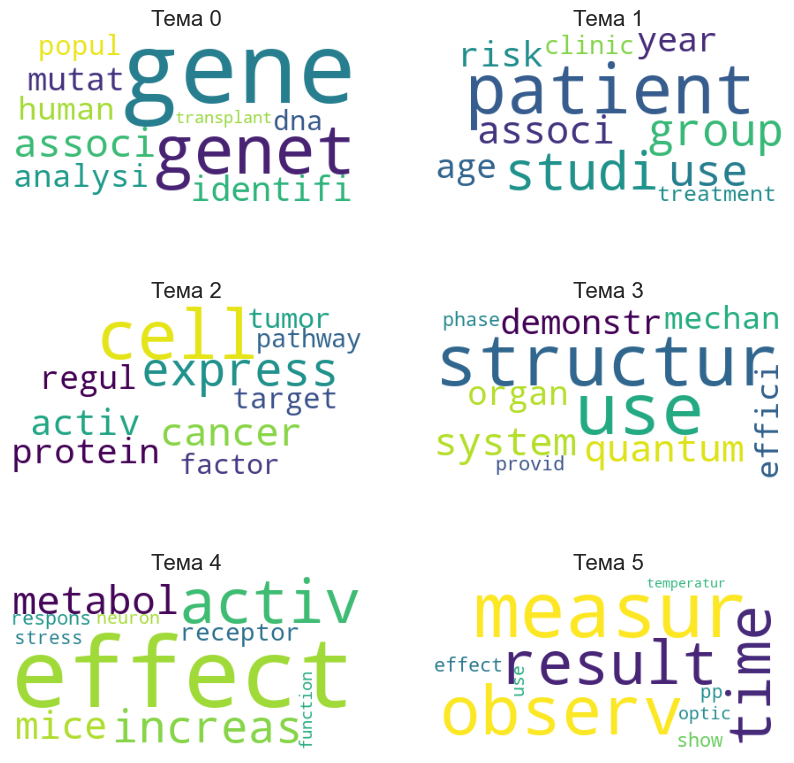

In [96]:
cloud = WordCloud(background_color='white')

topics = best_lda.show_topics(num_topics = 20, formatted=False)

fig, axes = plt.subplots(3, 2, figsize=(10,10))

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    cloud.generate_from_frequencies(dict(topics[i][1]))
    plt.gca().imshow(cloud)
    plt.gca().set_title('Тема ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')



plt.axis('off')
plt.show()

### Интрепретация тем на основе ключевых слов

#### Тема 0: Гены и генетика. Эта тема связана с идентификацией генов, мутациями, анализом генетических данных и ассоциациями с определенными популяциями. Вероятно, здесь идет речь о генетических исследованиях и генетической основе различных явлений.

#### Тема 1: Пациенты и клинические исследования. Эта тема связана с исследованиями, проводимыми на пациентах, и анализом групп пациентов. Она включает использование различных методов исследования, связанных с клиническими данными, рисками и лечением различных заболеваний.

#### Тема 2: Клетки и рак. Эта тема связана с исследованиями клеток, особенно раковых клеток. Она включает экспрессию генов, активацию белков, регуляцию их функций, а также отслеживание путей, связанных с раком.

#### Тема 3: Структуры и квантовая физика. Эта тема связана с исследованием структур и систем на микроуровне, включая квантовую физику. Она может включать в себя исследования структуры материалов, механизмов и физических процессов, связанных с квантовыми явлениями.

#### Тема 4: Эффекты и функции. Эта тема связана с исследованиями различных эффектов и функций в организмах или системах. Включает изучение эффектов активации, метаболизма, рецепторов, ответов на стресс и функций нейронов.

#### Тема 5: Измерения и оптика. Эта тема связана с измерениями и оптикой. Включает изучение методов измерений, наблюдений, оптических свойств и их взаимосвязи с результатами исследований.

In [97]:
d = {0 : "Гены и генетика",
     1 : "Пациенты и клинические исследования",
     2 : "Клетки и рак",
     3 : "Структуры и квантовая физика",
     4 : "Эффекты и функции",
     5 : "Измерения и оптика"}

### Выберем для каждой статьи доминирующую тему

In [109]:
def dominant_topic(x):
    bow = dictionary.doc2bow(x)
    doc_distribution = np.array([(int(tup[0]), tup[1]) for tup in best_lda.get_document_topics(bow=bow)])
    return d[int(sorted(doc_distribution, key = lambda x: x[1], reverse=True)[0][0])], round(sorted(doc_distribution, key = lambda x: x[1], reverse=True)[0][1], 2)

In [110]:
df['Topic']= df['tokenized'].apply(dominant_topic)

In [111]:
df.head()

,title,journal,eissn,doi,volume,issue,year,pages,author,affiliation,text,citation,contacts,tokenized,Topic
0,SPATA33 is an autophagy mediator for cargo sel...,Cell Death & Differentiation,1476-5403,10.1038/s41418-020-00638-2,28.0,3.0,2021.0,1076-1090,"Zhang, Ying;Xu, Xu;Hu, Mengxin;Wang, Xin;Cheng...","Zhang, Ying#:#Hubei Key Laboratory of Cell Hom...",Selective autophagic degradation of mitochondr...,citation_journal_title=Microsc Res Tech.; cita...,Hanhua Cheng#:#hhcheng@whu.edu.cn#;#Rongjia Zh...,"[select, autophag, degrad, mitochondria, impor...","(Эффекты и функции, 0.58)"
1,Carbohydrate recognition by Clostridium diffic...,Nature Structural & Molecular Biology,1545-9985,10.1038/nsmb1084,13.0,5.0,2006.0,460-461,"Greco, Antonio;Ho, Jason G S;Lin, Shuang-Jun;P...","Greco, Antonio#:#Alberta Ingenuity Centre for ...",Clostridium difficile TcdA is a large toxin th...,citation_journal_title=N. Engl. J. Med.; citat...,Kenneth K-S Ng#:#ngk@ucalgary.ca,"[difficil, larg, toxin, bind, carbohydr, intes...","(Структуры и квантовая физика, 0.48)"
2,Redshifts of 1548 + 115a and 1548 + 115b in th...,Nature,1476-4687,10.1038/250127a0,250.0,5462.0,1974.0,127-128,"CHERRY, NORMAN H.","CHERRY, NORMAN H.#:#University City Science Ce...",IN a recent communication Wampler et al.1 repo...,citation_journal_title=Nature; citation_author...,NaN,"[recent, commun, et, al, report, pair, given, ...","(Измерения и оптика, 0.6)"
3,Ocean sensitivity to freshwater,Nature Climate Change,1758-6798,10.1038/s41558-022-01324-6,12.0,5.0,2022.0,419-420,"Bakker, Pepijn","Bakker, Pepijn#:#Department of Earth Sciences,...",In response to future warming and freshening o...,citation_journal_title=Nat. Clim. Change; cita...,Pepijn Bakker#:#p.bakker@vu.nl,"[respons, futur, warm, north, atlant, ocean, c...","(Измерения и оптика, 0.48)"
4,Transplantation of Murine Leukæmia by Unconven...,Nature,1476-4687,10.1038/1911213a0,191.0,4794.0,1961.0,1213-1214,"HEWITT, HAROLD B.","HEWITT, HAROLD B.#:#John Burford Carlill Labor...",A LYMPHOCYTIC type of leukæmia which arose spo...,citation_journal_title=Brit. J. Cancer; citati...,NaN,"[lymphocyt, type, spontan, mous, strain, alrea...","(Гены и генетика, 0.31)"


### Теперь у каждой статьи выделена тема, к которой она относится. Рассмотрим распределение полученных тем

In [112]:
df['Topic'].apply(lambda x: x[0]).value_counts()

Topic
Пациенты и клинические исследования    1737
Измерения и оптика                     1699
Структуры и квантовая физика           1474
Клетки и рак                           1257
Гены и генетика                         782
Эффекты и функции                       766
Name: count, dtype: int64

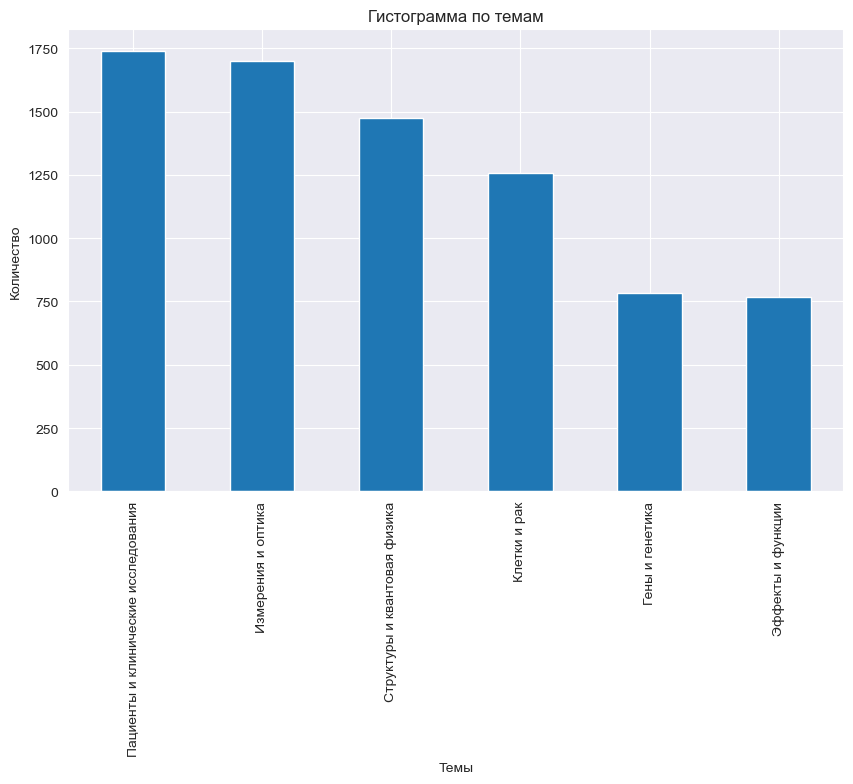

In [113]:
topic_counts = df['Topic'].apply(lambda x: x[0]).value_counts()

plt.figure(figsize=(10, 6))
topic_counts.plot(kind='bar')
plt.title('Гистограмма по темам')
plt.xlabel('Темы')
plt.ylabel('Количество')
plt.show()